## 1. Introduction
### 1.1 Project Description
This project builds a deep neural networks model that classifies breast tissues as cancerous or not based on histopathological images. We will use convolutional neural network (CNN) to first extract image features and then perform classification using a fully connected network.

The data set to be used is the PatchCamelyon (PCam) benchmark dataset.

### 1.2 Project Background
Breast cancer affects 1 in 8 females worldwide. There are various ways to screen breast cancer, including Mammography, Magnetic Resonance Imaging (MRI) Scans, Computed Tomography (CT) Scans, Ultrasound and Nuclear Imaging. Tissue-based diagnosis is then used to provide further evidence on results. Elements of tissues are colored by some staining element, and pathologists then examine these stained tissues under a microscope or using high resolution images taken from the camera. For detection of tumors, a histopathology test is essential.

Manual detection of a cancer cell is a tiresome process that often comes with errors, as it involves human judgement, and there are natural variations in cancer cells and tissues that make identification difficult.

As a result, machine learning models, and especially deep learning models have become a popular approach for automating cancer detection tasks. Traditional CV approaches often involve significant human feature engineering that involve domain expertise, while deep learning models can extract and organize different features automatically.

### 1.3 Project Goal and Evaluation
The goal of this project is to train an effective deep learning model with CNN to classify histopathological images as Benign (0) or Malignant (1). The model is evaluated on area under the ROC curve between the predicted probability and the observed target. This area is known as Area Under the Curve (AUC) and the higher the AUC the better the performance of the model at distinguishing between Benign and Malignant classes. We aim to achieve an AUC of greater than 0.92.

-------------------------------

## 2. The Data
### 2.1 Data Description
The data for this project is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size and approachability. The modified version that we use contains approximately 280k low-resolution images (96 x 96) of lymph node sections extracted from digital histopathological scans. Each image is labelled by trained pathologists for the presence of metastasised cancer. Each image file is also labelled with an image id. 220k of the images will be used for training and the remaining for testing.

### 2.2 Data Source
The data set can be found on [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data?select=train).

-----------------

## 3. Loading the Libraries and Data

### 3.1 Loading the Libraries

In [1]:
# 1. Loading the common modules
import os

from glob import glob # for matching filenames

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
from tqdm import notebook, trange # useful progress bar

import gc #garbage collection, we need to save all the RAM we can

In [2]:
# 2. Loading the deep learning and computer vision modules
import tensorflow as tf
import keras # high-level deep learning API
import cv2 # image processing and loading images

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

### 3.2 Loading the Data
We need to first create a data frame for holding the file path in the training_path folder and then read in all the matching labels (1-Malignant, 0-Benign) from the csv file.

In [3]:
# set paths to training and test data
# If on Kaggle, remember to "+ Add data" first

path = "../input/histopathologic-cancer-detection/" # change this path when running locally
training_path = path + 'train/'
test_path = path + 'test/'

print(training_path)
print(test_path)

df = pd.DataFrame({'path': glob(os.path.join(training_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head()

../input/histopathologic-cancer-detection/train/
../input/histopathologic-cancer-detection/test/


,path,id,label
0,../input/histopathologic-cancer-detection/trai...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/histopathologic-cancer-detection/trai...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/histopathologic-cancer-detection/trai...,b0d2582c6218a8764323fc940b41312282b99bf4,0
3,../input/histopathologic-cancer-detection/trai...,187c99df762f13f99818e5593d4bab4c6577e7e3,1
4,../input/histopathologic-cancer-detection/trai...,7c5270c83837de5a5cbb2dca511559dc39d19d53,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  object
 1   id      220025 non-null  object
 2   label   220025 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.7+ MB


We can see that the training data consists of 220025 observations. In our data frame, we have 3 features: 1) the file path, 2) the image id, 3) the known label (or class).

In [4]:
# We can now load the images
# Note that Kaggle GPU has limited RAM (of about 20GB), so we need to reduce
# Memory usage by keeping the imagings in uint8 format (0-255 pixel values)

# The images are 96x96 and RGB 3 channels
def load_image(N,data):
    """ This functions loads N images using the data
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(data['label'].values)[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in notebook.tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [6]:
# We can use different values of N, but here we will load 10,000 images
N  =10000
X,y = load_image(N=N,data=df) 
# Note sometimes tqdm doesn't display properly, often restarting the notebook will fix the problem.

  0%|          | 0/10000 [00:00<?, ?it/s]

### 3.3 Visualizing the Images
We can see that it is really hard to tell which image is cancerous and which is not with an untrained eye. At least I had no success at all when trying to guess the diagnosis outcome by looking at random images here, so it would be extremely interesting to see if we can build a model that detects cancer without any prior or domain knowledge using the deep learning model.

In [7]:
X[0][0][0] # We can see an example of the pixel values represented in the data

array([250, 246, 241], dtype=uint8)

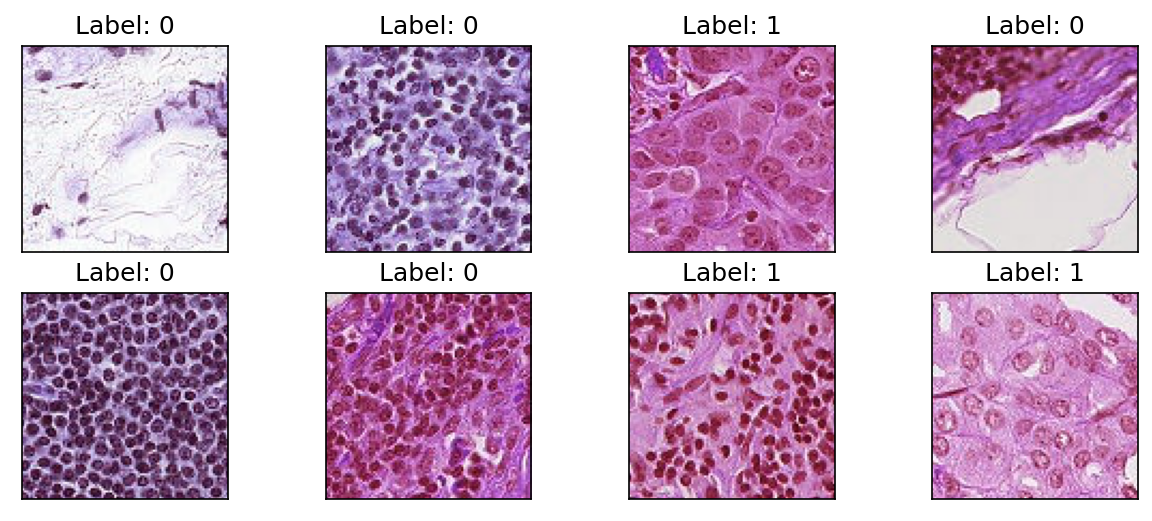

In [8]:
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(42) # As always, 42 is the answer to Everything :)
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx])
    ax.set_title('Label: ' + str(y[idx])) # label of each image 1-malignant, 0-benign

------------------

## 4. Exploratory Data Analysis (EDA)
### 4.1 Exploring data class/label distribution

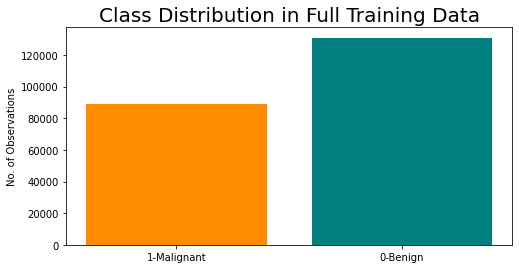

In [9]:
plt.figure(figsize = (8, 4))
plt.bar(['1-Malignant','0-Benign'], [(df.label == 1).sum(), (df.label == 0).sum()], color = ['darkorange','teal']);
plt.ylabel("No. of Observations")
plt.title("Class Distribution in Full Training Data", fontsize = 20);

In [10]:
df.label.value_counts(normalize = True)

0    0.594969
1    0.405031
Name: label, dtype: float64

We can see that we have more negative/benign samples than positive/malignant samples, and the ratio between positive/negative samples in the full training data is about 40%/60%. This observation helps us understand the baseline better, that is, if we built a brute-force classifier that predicted all images as negative (benign), then we'd achieve an accuracy of 60%. This also means that if we had to guess completely at random, our chance of getting at least half of our guesses correct is less than 3%. 

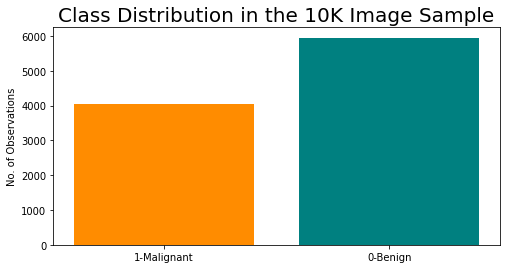

In [11]:
plt.figure(figsize = (8, 4))
plt.bar(['1-Malignant','0-Benign'], [(y == 1).sum(), (y == 0).sum()], color = ['darkorange','teal']);
plt.ylabel("No. of Observations")
plt.title("Class Distribution in the 10K Image Sample", fontsize = 20);

In [12]:
print(f'In the sample of 10K images, {round((y==1).sum()/len(y)*100, 2)}% are positive class (1-Malignant),\n' 
      f'and {round((y==0).sum()/len(y)*100, 2)}% are negative class (0-Benign).')

In the sample of 10K images, 40.47% are positive class (1-Malignant),
and 59.53% are negative class (0-Benign).


We can see that our sample of 10K images are fairly representative of the underlying training data, therefore for efficiency reasons, we can perform further EDA on the smaller subset of data.

### 4.2 Exploring the Positive and Negative Label Characteristics

In [13]:
negative = X[y == 0] # indexing X based on values of y
positive = X[y == 1]
print(len(negative), len(positive)) # sanity checking

5953 4047


The code below illustrates the pixel value distribution for each color channel in the RGB individually and combined (all 3 channels) using a series of histograms.

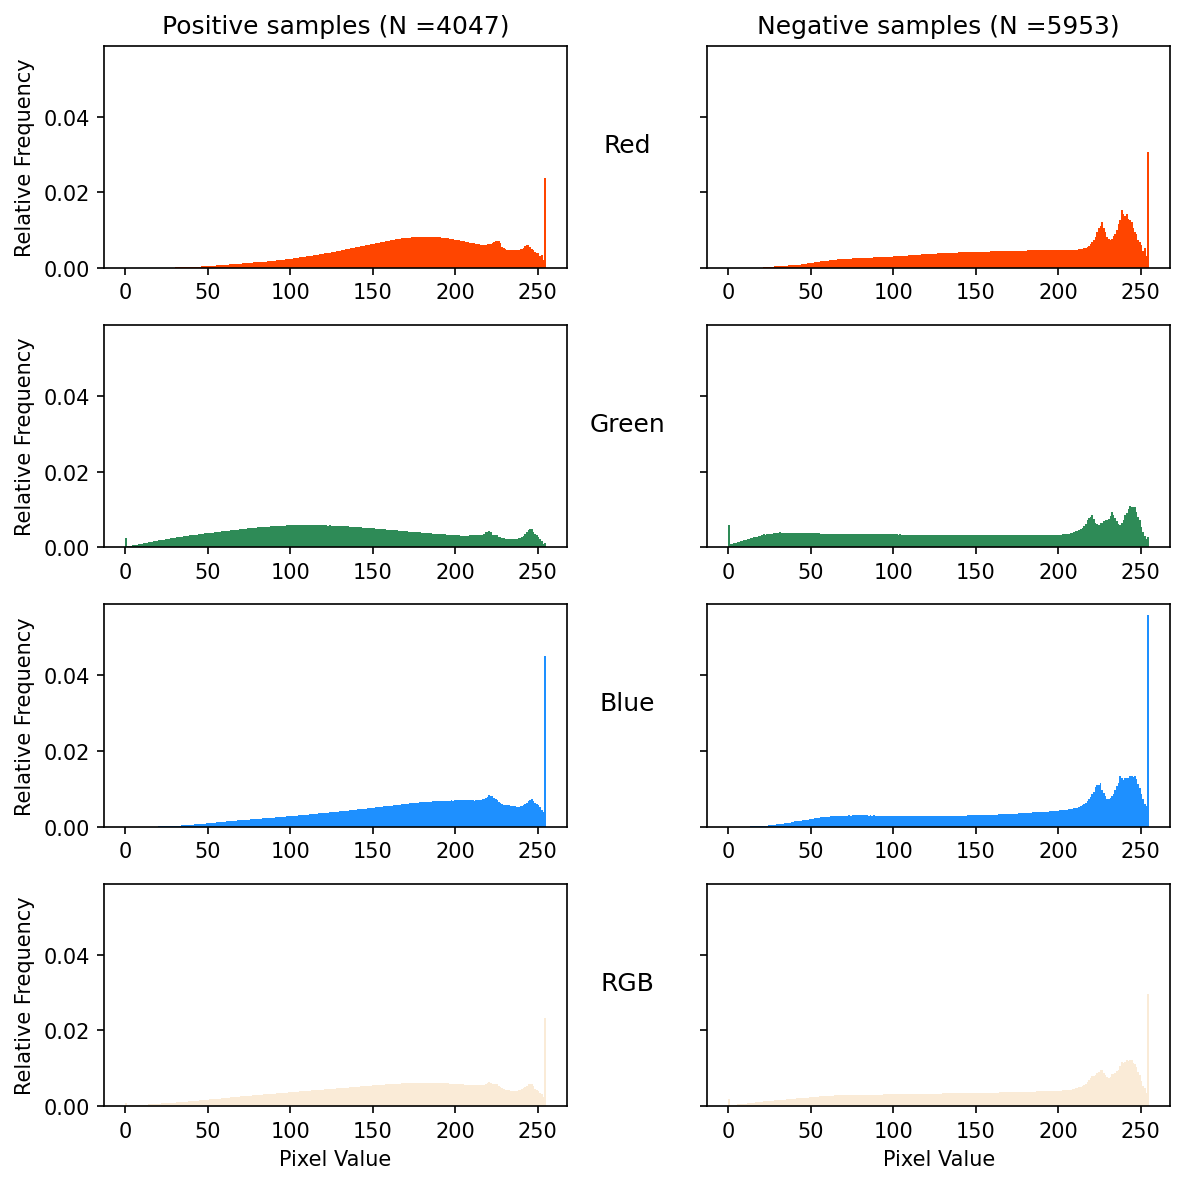

In [14]:
nr_of_bins = 256 #each pixel value will get a bin in the histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color = 'orangered')
axs[0,1].hist(negative[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color = 'orangered')
axs[1,0].hist(positive[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color = 'seagreen')
axs[1,1].hist(negative[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color = 'seagreen')
axs[2,0].hist(positive[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color = 'dodgerblue')
axs[2,1].hist(negative[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color = 'dodgerblue')

#All channels
# Fun fact, if you mix green, red and blue light, you actually get white light
axs[3,0].hist(positive.flatten(),bins=nr_of_bins,density=True, color = 'antiquewhite')
axs[3,1].hist(negative.flatten(),bins=nr_of_bins,density=True, color = 'antiquewhite')

#Setting image labels
axs[0,0].set_title("Positive samples (N =" + str(positive.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative Frequency")
axs[3,0].set_xlabel("Pixel Value")
axs[3,1].set_xlabel("Pixel Value")
fig.tight_layout()

#### Summary of Results - Pixel Distribution:
**1. Intra-class observations:**
* For both the Positive and Negative classes, there exists a high frequency of pixel value (at 255) for blue and red pixels. This corresponds to the bright white regions that are found in many images.   
* The Positive class contains more intensive/brighter pixels in the red and blue channel, while darker pixels in the green channel.
* The Negative class contains very intensive/brighter pixels in red, green and blue channels.
* Some very dark pixels are found (at 0) in both Positive and Negative classes' green channel.

**2. Inter-class observations:**
* Comparing the three channels between Positive and Negative classes, we can clearly see that proportionally more pixels in the Negative class are more intensive/brighter than those in the Positive class. Such difference is most apparent in the green channel, where more pixels are concentrated in the right for the Negative class, and more pixels are in the middle-left for the Positive class.

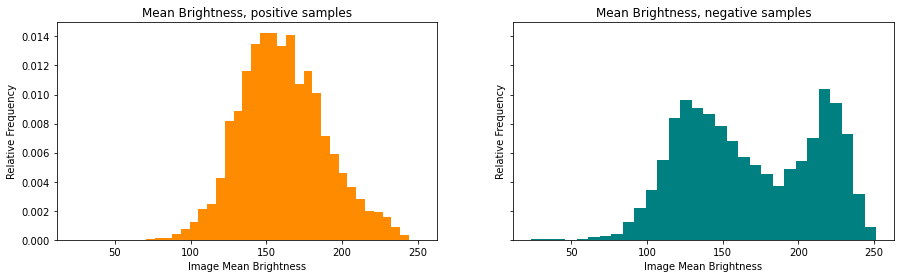

In [15]:
no_of_bins = 30 # adjust bin size for different smoothness of the plots
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(15,4))
axs[0].hist(np.mean(positive,axis=(1,2,3)),bins=no_of_bins,density=True, color = 'darkorange');
axs[1].hist(np.mean(negative,axis=(1,2,3)),bins=no_of_bins,density=True, color = 'teal');
axs[0].set_title("Mean Brightness, positive samples");
axs[1].set_title("Mean Brightness, negative samples");
axs[0].set_xlabel("Image Mean Brightness")
axs[1].set_xlabel("Image Mean Brightness")
axs[0].set_ylabel("Relative Frequency")
axs[1].set_ylabel("Relative Frequency");

#### Summary of Results - Image Brightness:
Without even careful examination, we can already see that there are clear differences between the Positive and Negative classes. The distribution of mean brightness for the Positive samples seems relatively normally distributed around a mean of 160. The Negative samples are bimodal with two peaks around 130 and 230 respectively.

It is reassuring to see the differences in image pixel characteristics between the positive and negative classes, because our deep learning models should be able to leverage on this difference and distinguish between different samples. We do however, have more Negative observations than Positive ones, so we might need to make the training set more balanced.

-----------

## 5. Modelling

### 5.1 Preparation
Previously for reasons of efficiency, we only loaded 10K data, now for actual model training, we will use the full data set. We can also use the garbage collector and free up some variables to improve RAM usage.

In [5]:
#N = df["label"].shape[0]
N = 180000
X,y = load_image(N=N,data=df)

  0%|          | 0/180000 [00:00<?, ?it/s]

In [6]:
positive = None
negative = None
gc.collect(); #use the garbage collector and free up some variables to improve RAM usage.

We can now split our data into train and validation sets. Since we have a relatively large number of images, we will use 90% of the data for training and 10% for validation. We will then shuffle the data to avoid potential influences that arise from the way prior sorting of data was done.

In [7]:
training_portion = 0.9
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(42)

#shuffling the index
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X_train = X[:split_idx]
y_train = y[:split_idx]
X_val = X[split_idx:]
y_val = y[split_idx:]

In [41]:
print(f'X train contains {X_train.shape}, and X validation contains {X_val.shape}')
print(f'y train contains {y_train.shape}, and y validation contains {y_val.shape}')

X train contains (162000, 96, 96, 3), and X validation contains (18000, 96, 96, 3)
y train contains (162000,), and y validation contains (18000,)


In [14]:
# defining a helper function for plotting results
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

### 5.2 Baseline Model
Building a good Neural Networks Model and a CNN model requires intuition, experience and logic. Before we get into model building, I'd like to acknowledge the following great resources for understanding ANN and CNN architectures and the associated hyperparameters:
1. [A guide to an efficient way to build neural network architectures - Part I](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b) focuses on the architecture of dense neural networks.
2. [A guide to an efficient way to build neural network architectures - Part II](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7) focuses on the architecture of CNN.
3. [Complete beginner's guide ](https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93) Gives examples of how to construct CNN model in Keras.

There are also tonnes of other resources available that provide great explanations.







We will start off with a very simple baseline model, that contains only 1 convolutional layer. We know that this won't be a great model, because it will only be able to extract limited features, but I am curious to know how such a simple model will perform compared with people with no domain knowledge.

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
conv1_filters = 32
stride_size = 3

model = Sequential()

# adding conv1 layer; no dropout or other regularization at this stage
model.add(Conv2D(conv1_filters, kernel_size, input_shape = (96, 96, 3), strides = stride_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(conv1_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 

# adding a dense/fully connected layer before output
model.add(Flatten())
model.add(Dense(64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))

# output layer performs binary classification, so we will use sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0

We will now decide on the loss function and optimizer algorithm. For the loss function we will use binary_crossentropy which is suitable for our task, and for the optimizer we will try to popular Adam algorithm. We will set batch size to 50 (loading 50 images to the model at each time). Learning rate is set to 2e-4.

In [44]:
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(2e-4), 
              metrics=['accuracy'])

In [53]:
history = model.fit(
    X_train,
    y_train,
    batch_size = batch_size, 
    epochs = 20,
    validation_data=(X_val, y_val),
)

2022-05-20 00:56:21.381908: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4478976000 exceeds 10% of free system memory.


Epoch 1/20
3240/3240 [==============================] - 14s 4ms/step - loss: 0.2711 - accuracy: 0.8874 - val_loss: 0.3333 - val_accuracy: 0.8624
Epoch 2/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.2468 - accuracy: 0.8992 - val_loss: 0.3404 - val_accuracy: 0.8502
Epoch 3/20
3240/3240 [==============================] - 14s 4ms/step - loss: 0.2238 - accuracy: 0.9098 - val_loss: 0.3849 - val_accuracy: 0.8359
Epoch 4/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.2014 - accuracy: 0.9200 - val_loss: 0.3381 - val_accuracy: 0.8614
Epoch 5/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1790 - accuracy: 0.9303 - val_loss: 0.3513 - val_accuracy: 0.8602
Epoch 6/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1576 - accuracy: 0.9399 - val_loss: 0.3989 - val_accuracy: 0.8453
Epoch 7/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1387 - accuracy: 0.9484 - val_loss: 0.4245 - val_ac

Validation Accuracy: [0.8550000190734863]


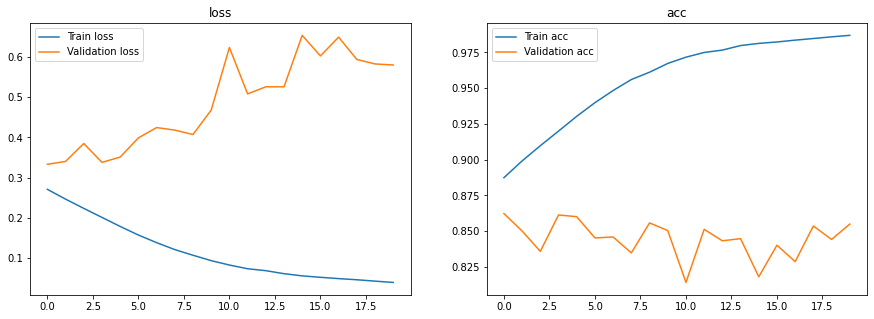

In [56]:
show_history(history)
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

#### Summary of Baseline Results
* We can clearly see that our baseline model is not a great one.
* The validation loss is always going up, and the validation accuracy seems to to be stagnating (or even decreasing) as epochs increase. This is a sign that our model is not learning properly through the iterations.
* The validation accuracy is always lower than the training accuracy, suggesting that there may be ways to improve our model results.
* It is important to note that although this baseline model is far from perfect, it in fact outperforms most untrained humans by a big margin. So for example, if a human predicted all images as benign, then they'd have an accuracy of 60%, whereas our model achieves an accuracy of 85.5%!

### 5.3 Improved Model
We can try to improve our results by making our model "deeper", that is by adding more convolutional layers to extracts features in more detail (or different levels of detail). The convolutional layers will learn detailed features first and then gradually learns more generalized features, therefore we will set the covolutional filters in increasing value, the first layer will have a filter size of 32, then 64 and 128 for the next two layers.

The activation function in the convolutional layers will be ReLU and the dense layer activation function will be sigmoid since we are predicting binary classes. BatchNormalization and MaxPooling layers are also added in the convolutional layers, as normalization is important for image analysis tasks, and maxpooling layer allows us to reduce the size of the feature map.

In [58]:
kernel_size = (3,3)
pool_size= (2,2)
conv1_filters = 32
conv2_filters = 64
conv3_filters = 128
stride_size = 2 # set a smaller stride this time

model = Sequential()

# adding conv1 layer; no dropout or other regularization at this stage
model.add(Conv2D(conv1_filters, kernel_size, input_shape = (96, 96, 3), strides = stride_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(conv1_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 

# adding conv2 layer; no dropout or other regularization at this stage
model.add(Conv2D(conv2_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(conv2_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))

# adding conv3 layer; no dropout or other regularization at this stage
model.add(Conv2D(conv3_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(conv3_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))

# adding a dense/fully connected layer before output
model.add(Flatten())
model.add(Dense(64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))

# output layer performs binary classification, so we will use sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

In [59]:
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(2e-4), 
              metrics=['accuracy'])

We will also add an early stopping component here, especially because we now have a larger model.

In [8]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto')

callback = [es]

In [62]:
history = model.fit(
    X_train,
    y_train,
    batch_size = batch_size, 
    epochs = 20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
3240/3240 [==============================] - 28s 8ms/step - loss: 0.3768 - accuracy: 0.8350 - val_loss: 0.4850 - val_accuracy: 0.7763
Epoch 2/20
3240/3240 [==============================] - 26s 8ms/step - loss: 0.3004 - accuracy: 0.8742 - val_loss: 0.2698 - val_accuracy: 0.8867
Epoch 3/20
3240/3240 [==============================] - 26s 8ms/step - loss: 0.2622 - accuracy: 0.8917 - val_loss: 0.3027 - val_accuracy: 0.8716
Epoch 4/20
3240/3240 [==============================] - 25s 8ms/step - loss: 0.2348 - accuracy: 0.9056 - val_loss: 0.4034 - val_accuracy: 0.8274
Epoch 5/20
3240/3240 [==============================] - 25s 8ms/step - loss: 0.2133 - accuracy: 0.9148 - val_loss: 0.4373 - val_accuracy: 0.8293
Epoch 6/20
3240/3240 [==============================] - 26s 8ms/step - loss: 0.1932 - accuracy: 0.9237 - val_loss: 0.2691 - val_accuracy: 0.8943
Epoch 7/20
3240/3240 [==============================] - 25s 8ms/step - loss: 0.1754 - accuracy: 0.9320 - val_loss: 0.2723 - val_ac

Validation Accuracy: [0.882611095905304]


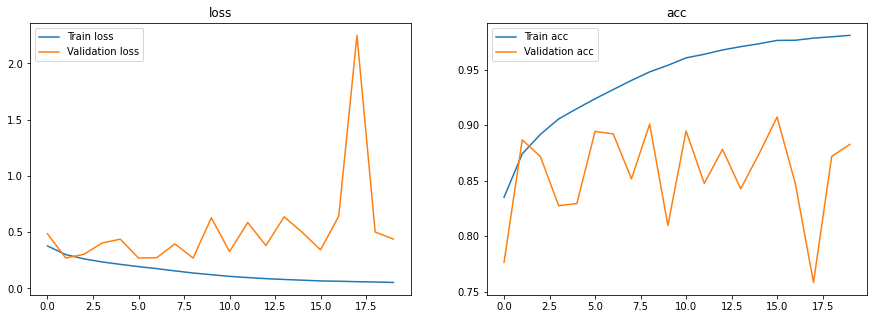

In [63]:
show_history(history)
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

#### Summary of Improved Model's Results
* We can see that our improved model indeed brings an improvement in modelling results. 
* The validation loss has decreased by a lot when compared with the baseline, and the validation accuracy has also noticeably shifted upwards compared with the baseline.
* The model's overall accuracy has increased from 85.5% to 88.3%.
* The validation accuracy is still lower than the training accuracy, suggesting that it may still be possible to further improve our model results.


### 5.4 Further Improving the Model
We can try to improve our model further by taking a more detailed approach towards filter size choice, and also by adding a dropout layer that reduces the possibility for overfitting. The values we choose for the filter/kernel size are generally small, and that's because based on looking at the images, the cancer cells are at the pixel level (which means the network doesn't need very large amounts of pixels to recognize cancer). And we set the filters in the first two convolutional layers to (3,3) to recognize the more fine-grained details, and set the third layer's filter to (5,5) for recognizing higher level, more global features.

In [ ]:
kernel_size1 = (3,3)
kernel_size2 = (3,3)
kernel_size3 = (5,5)

pool_size= (2,2)
conv1_filters = 32
conv2_filters = 64
conv3_filters = 128
#stride_size = 2 # set a smaller stride this time

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()

# adding conv1 layer; no dropout or other regularization at this stage
model.add(Conv2D(conv1_filters, kernel_size1, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(conv1_filters, kernel_size1, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))
          
# adding conv2 layer; no dropout or other regularization at this stage
model.add(Conv2D(conv2_filters, kernel_size2, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(conv2_filters, kernel_size2, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# adding conv3 layer; no dropout or other regularization at this stage
model.add(Conv2D(conv3_filters, kernel_size3, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(conv3_filters, kernel_size3, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))
          
# adding a dense/fully connected layer before output
model.add(Flatten())
model.add(Dense(64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# output layer performs binary classification, so we will use sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

In [10]:
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(2e-4), 
              metrics=['accuracy'])

In [13]:
history = model.fit(
    X_train,
    y_train,
    batch_size = batch_size, 
    epochs = 20,
    validation_data=(X_val, y_val),
    callbacks = callback,
)

2022-05-20 02:17:43.154286: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4478976000 exceeds 10% of free system memory.
2022-05-20 02:17:48.171576: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4478976000 exceeds 10% of free system memory.
2022-05-20 02:17:51.466897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-20 02:17:53.362414: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3240/3240 [==============================] - ETA: 0s - loss: 0.4022 - accuracy: 0.8274

2022-05-20 02:19:17.090287: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 497664000 exceeds 10% of free system memory.
2022-05-20 02:19:17.764067: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 497664000 exceeds 10% of free system memory.


3240/3240 [==============================] - 89s 25ms/step - loss: 0.4022 - accuracy: 0.8274 - val_loss: 0.5963 - val_accuracy: 0.7713
Epoch 2/20
3240/3240 [==============================] - 80s 25ms/step - loss: 0.3152 - accuracy: 0.8694 - val_loss: 0.4422 - val_accuracy: 0.8107
Epoch 3/20
3240/3240 [==============================] - 79s 25ms/step - loss: 0.2781 - accuracy: 0.8873 - val_loss: 0.4320 - val_accuracy: 0.8219
Epoch 4/20
3240/3240 [==============================] - 80s 25ms/step - loss: 0.2546 - accuracy: 0.8982 - val_loss: 0.2592 - val_accuracy: 0.8914
Epoch 5/20
3240/3240 [==============================] - 80s 25ms/step - loss: 0.2360 - accuracy: 0.9066 - val_loss: 0.2272 - val_accuracy: 0.9097
Epoch 6/20
3240/3240 [==============================] - 79s 24ms/step - loss: 0.2235 - accuracy: 0.9130 - val_loss: 0.2332 - val_accuracy: 0.9069
Epoch 7/20
3240/3240 [==============================] - 80s 25ms/step - loss: 0.2117 - accuracy: 0.9184 - val_loss: 0.3095 - val_accura

Validation Accuracy: [0.8846666812896729]


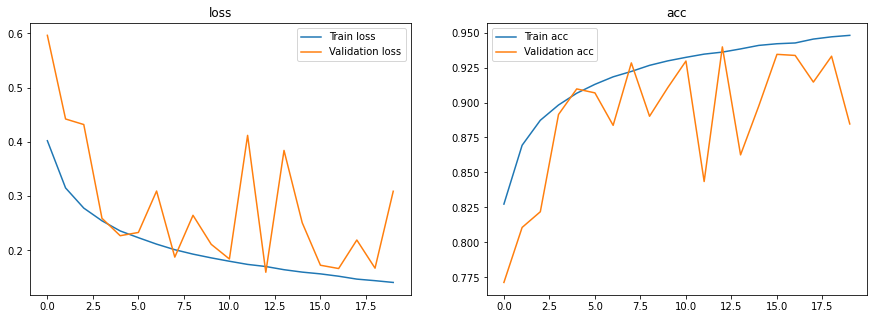

In [14]:
show_history(history)
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

#### Summary of 3rd Model's Results
* We can see that our 3rd model has again improved from previous models.
* The validation loss has decreased by a lot when compared with the baseline, and the validation accuracy has also noticeably shifted upwards compared with the baseline. We can see that the validation accuracy is on average much closer to the training accuracy.
* The model's overall accuracy has increased from 85.5% to 88.5%.

We might be able to further improve the model by adding additional layers (more depth), but due to limited computing resources available (as shown below) we can only stop here with our modelling. We will move onto hyperparameter tuning in the next section to see if we can further improve our model results.

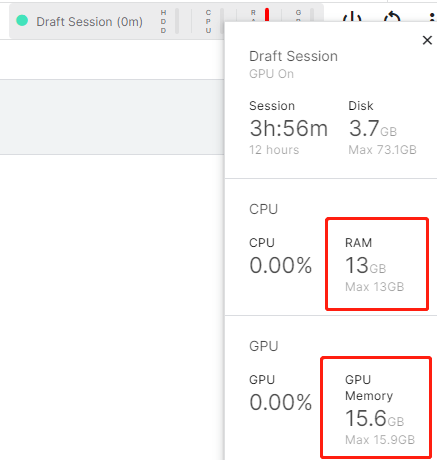

----------------

## 6. Hyperparameter Tuning and Optimization
There are many ways to do hyperparameter tuning:
* First, we could use loop over different combination of hyperparameter values in model fitting, much like doing a grid-search.
* Another popular approach is to automatically search for the optimal hyperparameters using Bayesian Optimization or Random Search. This can be done with Python packages such as Keras Tuner.
* However due to the very limited computing resources available, here we will take a more manual process and try fewer hyparameter combinations so that the notebook won't constantly crash/restart.
* If we had a local GPU or more abundament cloud resources, we would choose a more sophisticated tuning method.

### 6.1 Tuning the Learning Rate
Learning rate is one of the most important hyperparameters, we don't want a learning rate that is too high wherein we are unable to converge to global minima, and not too low either such that we are extremely slow to converge. We usually try powers of 10, e.g. 0.0001, 0.001, 0.01 etc. But we can of course try any learning rate and see what works well. For the Adam optimizer, usually the recommended rate is around 1e-3~1e4.

In [19]:
learning_rate = 2e-3 # originally 2e-4

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate), 
              metrics=['accuracy'])

In [20]:
history = model.fit(
    X_train,
    y_train,
    batch_size = batch_size, 
    epochs = 20,
    validation_data=(X_val, y_val),
    callbacks = callback,
)

2022-05-20 03:13:34.088763: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4478976000 exceeds 10% of free system memory.


Epoch 1/20
3240/3240 [==============================] - 81s 25ms/step - loss: 0.2424 - accuracy: 0.9060 - val_loss: 0.2883 - val_accuracy: 0.8825
Epoch 2/20
3240/3240 [==============================] - 80s 25ms/step - loss: 0.2092 - accuracy: 0.9196 - val_loss: 0.5337 - val_accuracy: 0.7939
Epoch 3/20
3240/3240 [==============================] - 79s 24ms/step - loss: 0.1935 - accuracy: 0.9276 - val_loss: 1.2339 - val_accuracy: 0.7293
Epoch 4/20
3240/3240 [==============================] - 79s 25ms/step - loss: 0.1781 - accuracy: 0.9330 - val_loss: 0.7397 - val_accuracy: 0.7952
Epoch 5/20
3240/3240 [==============================] - 79s 24ms/step - loss: 0.1689 - accuracy: 0.9371 - val_loss: 0.2148 - val_accuracy: 0.9098
Epoch 6/20
3240/3240 [==============================] - 79s 24ms/step - loss: 0.1598 - accuracy: 0.9407 - val_loss: 0.7567 - val_accuracy: 0.7786
Epoch 7/20
3240/3240 [==============================] - 79s 24ms/step - loss: 0.1515 - accuracy: 0.9444 - val_loss: 0.2304 -

Validation Accuracy: [0.8824999928474426]


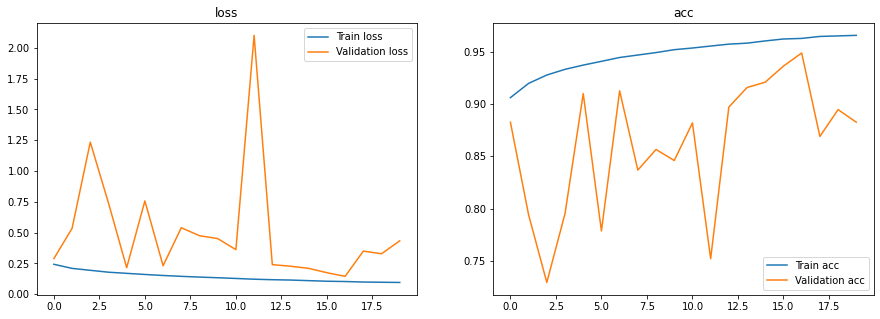

In [21]:
show_history(history)
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

We can see that our loss and accuracy for the validation data is oscillating quite a lot, this suggests that the chosen learning rate is potentially too large, making the loss "bouncing around". Let's try a smaller learning rate next.

In [13]:
learning_rate = 6e-4 # originally 2e-4

batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate), 
              metrics=['accuracy'])

In [14]:
history = model.fit(
    X_train,
    y_train,
    batch_size = batch_size, 
    epochs = 20,
    validation_data=(X_val, y_val),
    callbacks = callback
)

2022-05-20 04:09:20.834752: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4478976000 exceeds 10% of free system memory.
2022-05-20 04:09:25.823244: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4478976000 exceeds 10% of free system memory.
2022-05-20 04:09:29.325788: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-20 04:09:31.216407: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3239/3240 [============================>.] - ETA: 0s - loss: 0.3705 - accuracy: 0.8427

2022-05-20 04:10:54.344408: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 497664000 exceeds 10% of free system memory.
2022-05-20 04:10:55.046085: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 497664000 exceeds 10% of free system memory.


3240/3240 [==============================] - 89s 25ms/step - loss: 0.3705 - accuracy: 0.8427 - val_loss: 0.4403 - val_accuracy: 0.8049
Epoch 2/20
3240/3240 [==============================] - 79s 24ms/step - loss: 0.2843 - accuracy: 0.8846 - val_loss: 0.4591 - val_accuracy: 0.8067
Epoch 3/20
3240/3240 [==============================] - 79s 24ms/step - loss: 0.2507 - accuracy: 0.9019 - val_loss: 0.6703 - val_accuracy: 0.7784
Epoch 4/20
3240/3240 [==============================] - 79s 24ms/step - loss: 0.2265 - accuracy: 0.9122 - val_loss: 0.7588 - val_accuracy: 0.7671
Epoch 5/20
3240/3240 [==============================] - 80s 25ms/step - loss: 0.2111 - accuracy: 0.9195 - val_loss: 0.2514 - val_accuracy: 0.8936
Epoch 6/20
3240/3240 [==============================] - 79s 24ms/step - loss: 0.1979 - accuracy: 0.9252 - val_loss: 0.2238 - val_accuracy: 0.9063
Epoch 7/20
3240/3240 [==============================] - 80s 25ms/step - loss: 0.1874 - accuracy: 0.9296 - val_loss: 0.3211 - val_accura

Validation Accuracy: [0.9244999885559082]


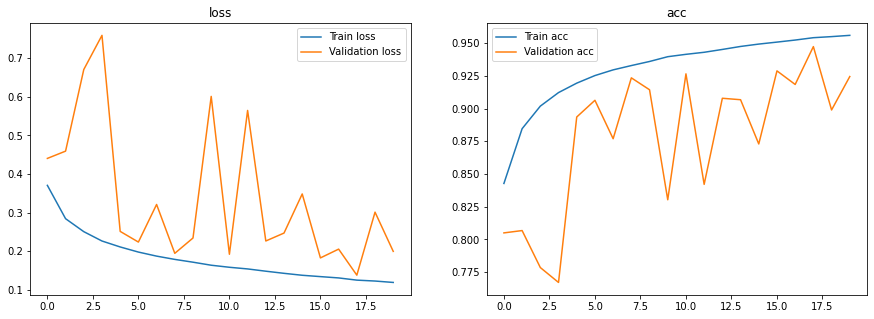

In [15]:
show_history(history)
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

We can see that although the validation loss and accuracy are still oscillating, the general trend is actually clearer than before, and we do get a noticeably higher validation accuracy score of 92.4% the highest so far, suggesting that this chosen learning rate is perhaps a better choice.

### 6.2 Tuning the Batch Size
Batch size is another important hyperparameter. If the batch size is large, learning would become slower, but if the batch size is too small, the weight updates would be quite random and convergence would become difficult. Usually it is recommended to try batch sizes in powers of 2.

In [11]:
# batch_size = 50**2 #originally 50

# learning_rate = 6e-4 # originally 2e-4

# model.compile(loss=keras.losses.binary_crossentropy,
#               optimizer=tf.keras.optimizers.Adam(learning_rate), 
#               metrics=['accuracy'])

In [ ]:
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size = batch_size, 
#     epochs = 20,
#     validation_data=(X_val, y_val),
#     callbacks = callbackac
# )

In [ ]:
# show_history(history)
# print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

Unfortunately the larger batch sized caused our notebook to exceed our allocated memory and computing resources, which made the notebook crash and restart.

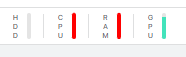

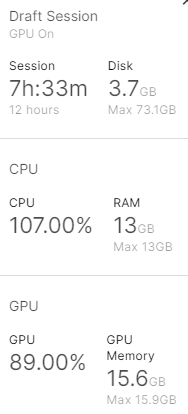

### 6.3 Tuning the Epochs
The number of epochs is the same as the number of iterations or times the training data is used to train the model. High epochs will likely cause model overfitting the training data and create generalization problems. If epochs are set to too low, then the model may not have an opportunity to learn all the features, and we would be underfitting. We will increase our epochs from 20 to 30, and we will also use an early stopping to try to reduce over training.

In [10]:
batch_size = 50 #originally 50

learning_rate = 6e-4 # originally 2e-4

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate), 
              metrics=['accuracy'])

In [12]:
history = model.fit(
    X_train,
    y_train,
    batch_size = batch_size, 
    epochs = 30,
    validation_data=(X_val, y_val),
    callbacks = callback
)

2022-05-20 06:22:05.345098: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4478976000 exceeds 10% of free system memory.
2022-05-20 06:22:10.380321: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4478976000 exceeds 10% of free system memory.
2022-05-20 06:22:13.646373: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-20 06:22:15.593512: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3240/3240 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8438

2022-05-20 06:23:38.797356: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 497664000 exceeds 10% of free system memory.
2022-05-20 06:23:39.467289: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 497664000 exceeds 10% of free system memory.


3240/3240 [==============================] - 88s 25ms/step - loss: 0.3684 - accuracy: 0.8438 - val_loss: 0.3766 - val_accuracy: 0.8244
Epoch 2/30
3240/3240 [==============================] - 79s 24ms/step - loss: 0.2875 - accuracy: 0.8846 - val_loss: 0.7189 - val_accuracy: 0.7846
Epoch 3/30
3240/3240 [==============================] - 80s 25ms/step - loss: 0.2443 - accuracy: 0.9047 - val_loss: 0.4115 - val_accuracy: 0.8328
Epoch 4/30
3240/3240 [==============================] - 79s 24ms/step - loss: 0.2230 - accuracy: 0.9142 - val_loss: 0.4674 - val_accuracy: 0.8176
Epoch 5/30
3240/3240 [==============================] - 79s 24ms/step - loss: 0.2077 - accuracy: 0.9209 - val_loss: 0.2457 - val_accuracy: 0.9014
Epoch 6/30
3240/3240 [==============================] - 79s 25ms/step - loss: 0.1957 - accuracy: 0.9262 - val_loss: 0.9828 - val_accuracy: 0.7486
Epoch 7/30
3240/3240 [==============================] - 79s 24ms/step - loss: 0.1865 - accuracy: 0.9305 - val_loss: 0.9052 - val_accura

Validation Accuracy: [0.8989999890327454]


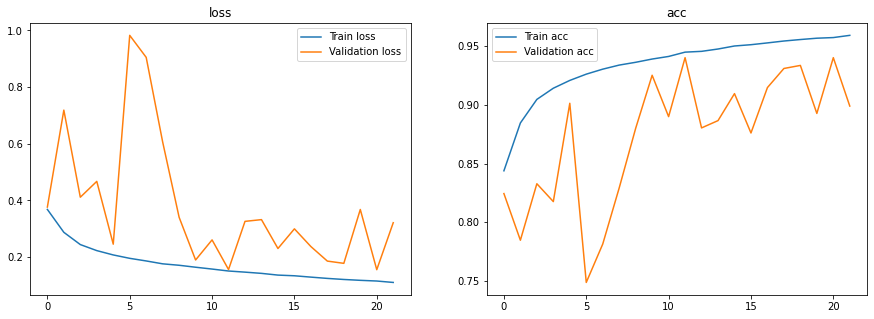

In [15]:
show_history(history)
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

We can see that the results are similar to the previous versions, and in fact the model early stopped at the 22nd epoch, which is very close to our originally set 20 epochs.

--------

## 7. Discussion and Analysis of Results

### 7.1 Summary of Results
Our best model is the model with 3 convolutional layers with drop-out and varying filter sizes, and a learning rate of 6e-4. We can see more detailed comparisons from the table below.

|Model|Accuracy on Validation| AUC on Test Data|
|:---:|:--------------------:|:---------------:|
|1) Baseline - Single Conv. Layer|0.8550|-|
|2) 3 Conv. Layers w/o Drop-out|0.8826|-|
|3) 3 Conv. Layers with Drop-out & Different Filter Sizes|0.8847|0.8920|
|4) 3rd Model with 2e-3 Learning Rate|0.8825|-|
|5) 3rd Model with 6e-4 Learning Rate|0.9245|0.9325|
|6) 5th Model with Epoch = 30|0.9000|0.8596|

### 7.2 Summary of Modelling and Tuning Choices



#### Modelling

**Baseline:**
* The simple baseline model only contains 1 convolutional layer. The filter/kernel size is set to (3,3), with 32 filters. 
* For the loss function we used binary_crossentropy which is suitable for our task of binary classification, and for the optimizer we will try to popular Adam algorithm. 
* We set batch size to 50 (loading 50 images to the model at each time). Learning rate is set to 2e-4.
* We can clearly see that our baseline model is not a great one.
* The validation loss is always going up, and the validation accuracy seems to to be stagnating (or even decreasing) as epochs increase. This is a sign that our model is not learning properly through the iterations.
* The validation accuracy is always lower than the training accuracy, suggesting that there may be ways to improve our model results.
* It is important to note that although this baseline model is far from perfect, it in fact outperforms most untrained humans by a big margin. So for example, if a human predicted all images as benign, then they'd have an accuracy of 60%, whereas our model achieves an accuracy of 85.5%!

**3 Convolutional Layers w/o Drop-out:**
* Our improved model was deeper than the baseline, with 2 more convolutional layers added. The convolutional layers will learn detailed features first and then gradually learns more generalized features, therefore we will set the covolutional filters in increasing value, the first layer will have a filter size of 32, then 64 and 128 for the next two layers.
* We can see that our improved model indeed brings an improvement in modelling results.
* The validation loss has decreased by a lot when compared with the baseline, and the validation accuracy has also noticeably shifted upwards compared with the baseline.
* The model's overall accuracy has increased from 85.5% to 88.3%.
* The validation accuracy is still lower than the training accuracy, suggesting that it may still be possible to further improve our model results.

**3 Convolutional Layers with Drop-out & Different Filter Sizes:**
* For the third model, we took a more detailed approach towards filter size choice, and also by adding a dropout layer that reduces the possibility for overfitting. The values we choose for the filter/kernel size are generally small, and that's because based on looking at the images, the cancer cells are at the pixel level (which means the network doesn't need very large amounts of pixels to recognize cancer). And we set the filters in the first two convolutional layers to (3,3) to recognize the more fine-grained details, and set the third layer's filter to (5,5) for recognizing higher level, more global features.
* We can see that our 3rd model has again improved from previous models.
* The validation loss has decreased by a lot when compared with the baseline, and the validation accuracy has also noticeably shifted upwards compared with the baseline. We can see that the validation accuracy is on average much closer to the training accuracy.
* The model's overall accuracy has increased from 85.5% to 88.5%.

#### Hyperparameter Tuning

**Tuning the Learning Rate**
* Learning rate is one of the most important hyperparameters, we don't want a learning rate that is too high wherein we are unable to converge to global minima, and not too low either such that we are extremely slow to converge. We usually try powers of 10, e.g. 0.0001, 0.001, 0.01 etc. But we can of course try any learning rate and see what works well. For the Adam optimizer, usually the recommended rate is around 1e-3~1e4.
* When learning rate = 2e-3, we can see that our loss and accuracy for the validation data is oscillating quite a lot. It didn't work well because the chosen learning rate is potentially too large, making the loss "bouncing around". 
* When learning rate = 6e-4, we do get a noticeably higher validation accuracy score of 92.4% the highest so far, suggesting that this chosen learning rate is perhaps a better choice.

**Tuning the Batch Size**
* Batch size is another important hyperparameter. If the batch size is large, learning would become slower, but if the batch size is too small, the weight updates would be quite random and convergence would become difficult. Usually it is recommended to try batch sizes in powers of 2.
* However tuning the batch size wasn't successful in our case, as unfortunately the larger batch sized caused our notebook to exceed our allocated memory and computing resources, which made the notebook crash and restart.

**Tuning the Number of Epochs**
* The number of epochs is the same as the number of iterations or times the training data is used to train the model. High epochs will likely cause model overfitting the training data and create generalization problems. If epochs are set to too low, then the model may not have an opportunity to learn all the features, and we would be underfitting. We will increase our epochs from 20 to 30, and we will also use an early stopping to try to reduce over training.
* We can see that the results are similar to the previous versions, and in fact the model early stopped at the 22nd epoch, which is very close to our originally set 20 epochs. This explains why increasing the number of epochs did not significantly improve our results, as we already had a good number of epochs for training.



-------

## 8. Conclusion

Breast cancer affects one in eight females worldwide, and early detection of the disease can greatly help increase the patient's survival rate. Traditional methods often reply on human pathologists to tiresomely examine stained tissues using high resolution images taken from the camera or under a microscope, which is prone to errors and is often slow. The goal of this project is to create a convolutional neural network (CNN) model that trains on PCam data and predicts whether an images contains cancerous cells or not. The aim is to achieve an AUC of at least 0.92. Our final model contains 3 convolutional layers with drop-out and a final dense layer with a sigmoid activation function. The final model achieves an AUC score of more than 0.93 on the test data, and is greater than our target of 0.92. This project was limited by the amount of computing resources available, and with enough computing power, we should be able to raise the score even further. 

-----------------

#### Submission Code

In [16]:
base_test_dir = path + 'test/' #specify test data folder
test_files = glob(os.path.join(base_test_dir,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
file_batch = 5000 #we will predict 5000 images at a time
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0]) #add the ids to the dataframe
    test_df['image'] = test_df['path'].map(cv2.imread) #read the batch
    K_test = np.stack(test_df["image"].values) #convert to numpy array
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines

Indexes: 0 - 5000
157/157 [==============================] - 1s 4ms/step
Indexes: 5000 - 10000
157/157 [==============================] - 1s 4ms/step
Indexes: 10000 - 15000
157/157 [==============================] - 1s 4ms/step
Indexes: 15000 - 20000
157/157 [==============================] - 1s 4ms/step
Indexes: 20000 - 25000
157/157 [==============================] - 1s 4ms/step
Indexes: 25000 - 30000
157/157 [==============================] - 1s 4ms/step
Indexes: 30000 - 35000
157/157 [==============================] - 1s 4ms/step
Indexes: 35000 - 40000
157/157 [==============================] - 1s 4ms/step
Indexes: 40000 - 45000
157/157 [==============================] - 1s 4ms/step
Indexes: 45000 - 50000
157/157 [==============================] - 1s 4ms/step
Indexes: 50000 - 55000
157/157 [==============================] - 1s 4ms/step
Indexes: 55000 - 60000
77/77 [==============================] - 0s 5ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.009569
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.007790
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.000700
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.021502
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.081671


In [17]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

In [1]:
#from IPython.display import FileLink
#FileLink('submission.csv')